In [69]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data import ConcatDataset
from sklearn.metrics import confusion_matrix, roc_curve, auc
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split
from torchvision.transforms import transforms
import torchvision.datasets as datasets
import random
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import label_binarize


In [70]:
mnist_trainset = datasets.MNIST(root='./data', train=True, download=True,transform=transforms.Compose([transforms.ToTensor()]))
mnist_testset = datasets.MNIST(root='./data', train=False, download=True,transform=transforms.Compose([transforms.ToTensor()]))

In [77]:
train_data = mnist_trainset.data.numpy().astype(np.float64)
test_data = mnist_testset.data.numpy().astype(np.float64)
total_data = np.concatenate((train_data, test_data), axis=0)
X = total_data.reshape(-1, 28*28)
print(X.shape)

train_targets = mnist_trainset.targets.numpy().astype(np.float64)
test_targets = mnist_testset.targets.numpy().astype(np.float64)
Y = np.concatenate((train_targets, test_targets))
print(Y.shape)


(70000, 784)


In [72]:
mean = np.mean(X, axis=0)
X_mean = X - mean
covMatrix = np.cov(X_mean.T)
eigVals, eigVec = np.linalg.eig(covMatrix)

i = eigVals.argsort()[::-1]
eigVals = eigVals[i]
sorted_eigVec = eigVec[:, i]
dimensionality_EigVec = sorted_eigVec[:,:100] #num of components
explained_var = eigVals / np.sum(eigVals)
cumulative_var = np.cumsum(explained_var)
print("Explained Variance : \n", explained_var)
print("Cumulative Variance : \n", cumulative_var)

projected_vals = np.dot(X_mean, dimensionality_EigVec)

X_train, X_test, y_train, y_test = train_test_split(projected_vals,Y,test_size=0.3)

Xtr = torch.tensor(X_train).float()
Xts = torch.tensor(X_test).float()
Ytr = torch.tensor(y_train).float()
Yts = torch.tensor(y_test).float()

class KNN():
    def __init__(self, k):
        self.k = k
    
    def fit(self, X, y):
        self.X = X
        self.y = y
    
    def predict(self, X):
        dists = torch.cdist(X, self.X)
        k_distances, indices = torch.topk(dists, self.k, dim=1, largest=False)
        y_pred = torch.mode(self.y[indices], dim=1).values
        return y_pred


knn = KNN (k = 3)
knn.fit(Xtr, Ytr)
KNN_Predictions = knn.predict(Xts)


CL when k =  3
              precision    recall  f1-score   support

         0.0       0.98      0.99      0.99      2044
         1.0       0.97      0.99      0.98      2343
         2.0       0.98      0.97      0.98      2121
         3.0       0.97      0.97      0.97      2166
         4.0       0.98      0.97      0.98      2030
         5.0       0.97      0.96      0.97      1925
         6.0       0.98      0.99      0.99      2053
         7.0       0.97      0.98      0.98      2204
         8.0       0.99      0.95      0.97      2039
         9.0       0.95      0.97      0.96      2075

    accuracy                           0.98     21000
   macro avg       0.98      0.98      0.98     21000
weighted avg       0.98      0.98      0.98     21000



<AxesSubplot:>

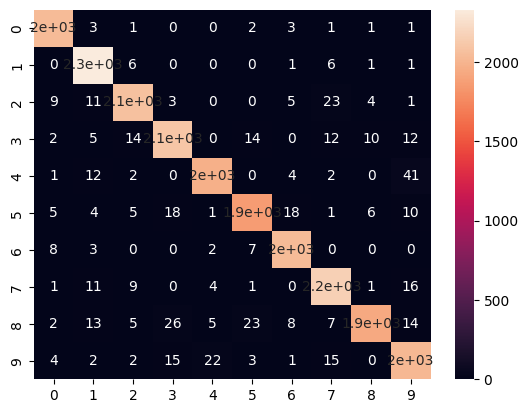

In [73]:
print("CL when k = ", 3)
print(classification_report(Yts,KNN_Predictions))

cm = confusion_matrix(Yts, KNN_Predictions)
sns.heatmap(cm, annot=True)

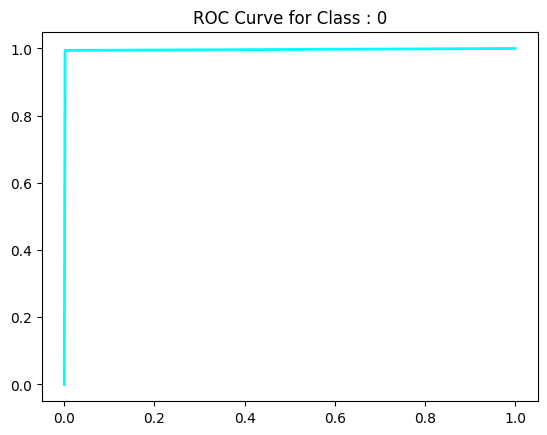

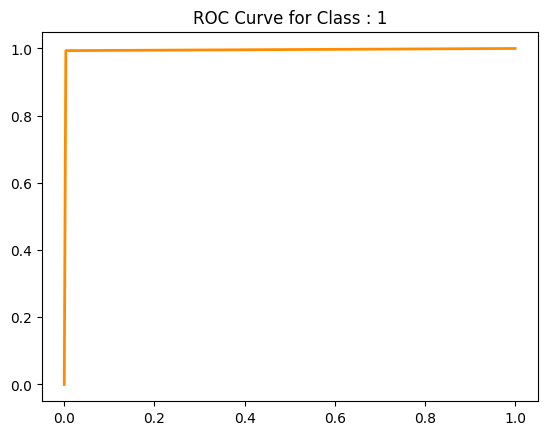

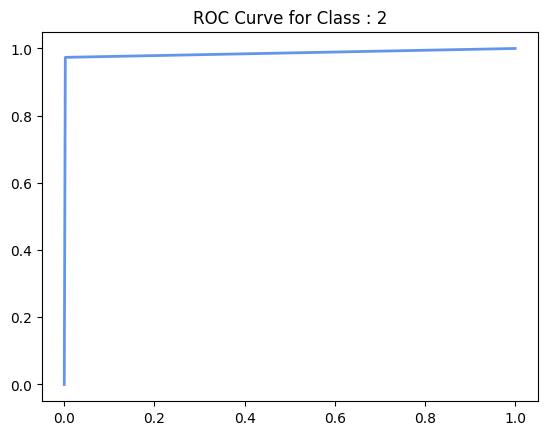

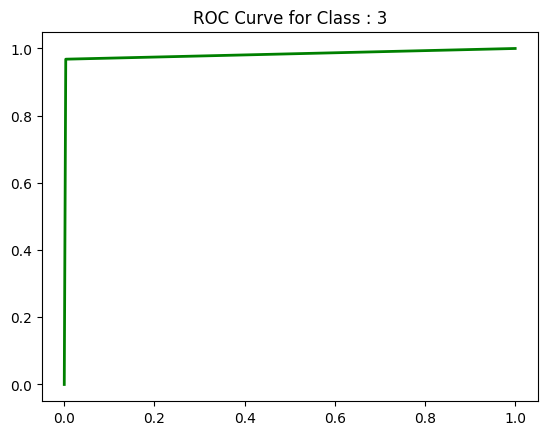

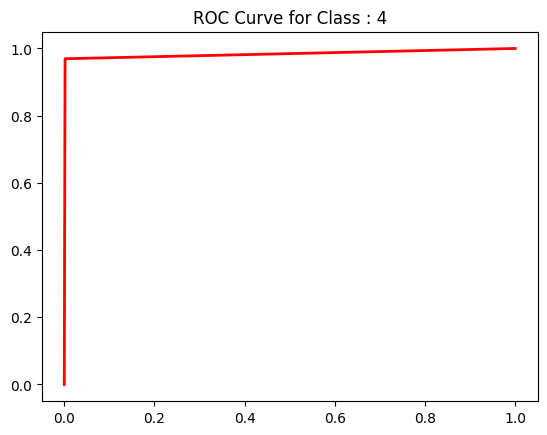

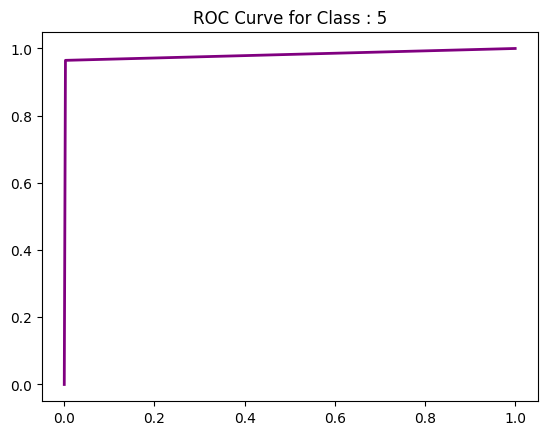

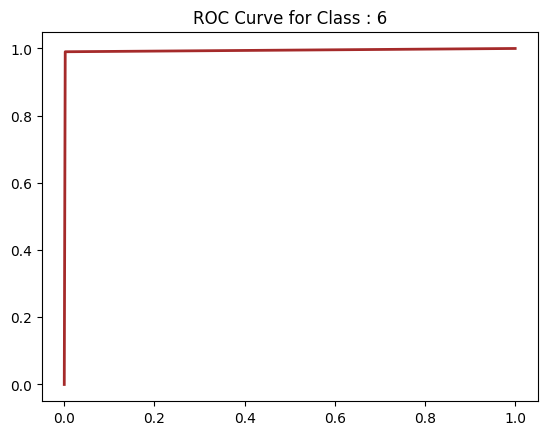

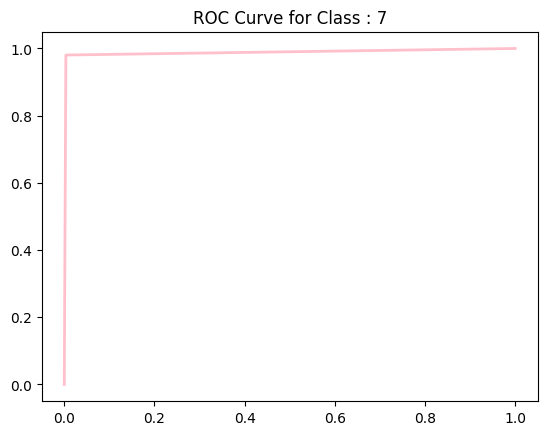

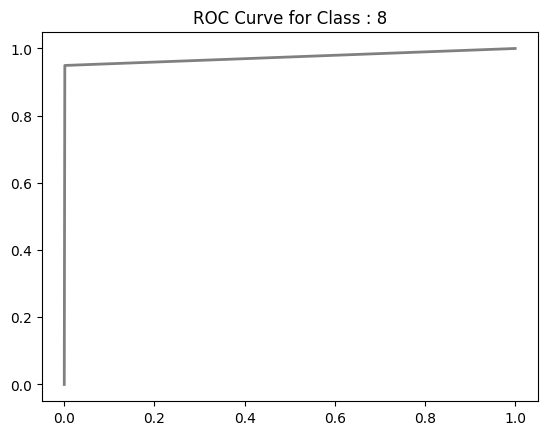

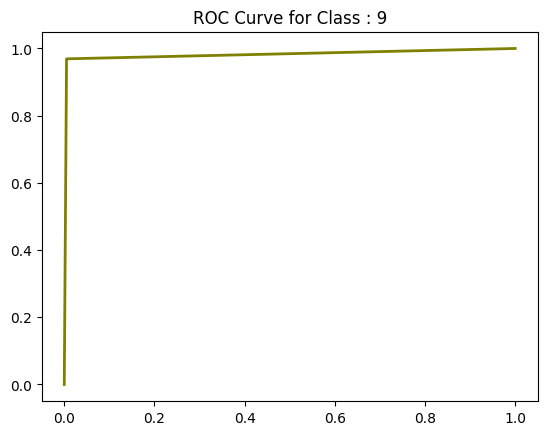

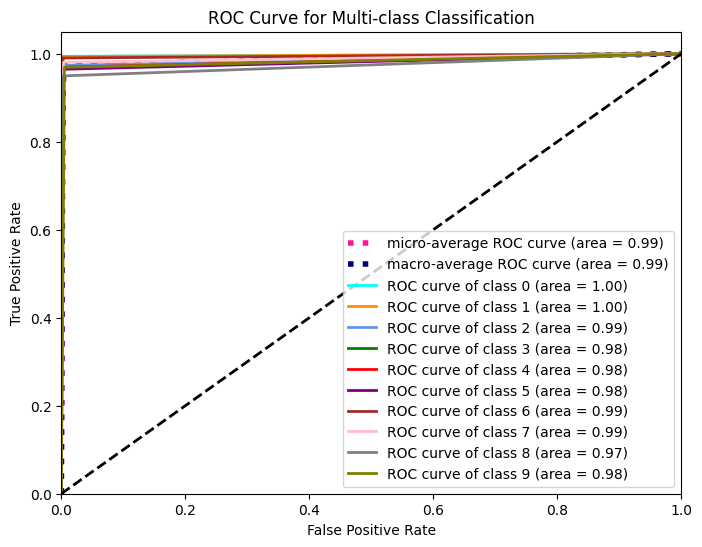

In [74]:
colors = ['aqua', 'darkorange', 'cornflowerblue', 'green', 'red', 'purple', 'brown', 'pink', 'gray', 'olive']
n_classes = 10
lw = 2
y_test = label_binarize(Yts, classes=[*range(n_classes)])
y_scores = label_binarize(KNN_Predictions, classes=[*range(n_classes)])
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test[:, i], y_scores[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])
    plt.title('ROC Curve for Class : %s' % i)
    plt.plot(fpr[i], tpr[i], color=colors[i], lw=lw,
             label='ROC curve of class {0} (area = {1:0.2f})'
             ''.format(i, roc_auc[i]))
    plt.show()

fpr["micro"], tpr["micro"], _ = roc_curve(y_test.ravel(), y_scores.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))

mean_tpr = np.zeros_like(all_fpr)
for i in range(n_classes):
    mean_tpr += np.interp(all_fpr, fpr[i], tpr[i])

mean_tpr /= n_classes

fpr["macro"] = all_fpr
tpr["macro"] = mean_tpr
roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

plt.figure(figsize=(8, 6))
plt.plot(fpr["micro"], tpr["micro"],
         label='micro-average ROC curve (area = {0:0.2f})'
               ''.format(roc_auc["micro"]),
         color='deeppink', linestyle=':', linewidth=4)

plt.plot(fpr["macro"], tpr["macro"],
         label='macro-average ROC curve (area = {0:0.2f})'
               ''.format(roc_auc["macro"]),
         color='navy', linestyle=':', linewidth=4)

for i, color in zip(range(n_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=lw,
             label='ROC curve of class {0} (area = {1:0.2f})'
             ''.format(i, roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--', lw=lw)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for Multi-class Classification')
plt.legend(loc="lower right")
plt.show()

In [75]:
randomInt = random.randint(0, len(Yts))
print(randomInt)

99


In [76]:
pointPrediction = knn.predict(Xts[randomInt].unsqueeze(0))
print('Predicted Label : ', pointPrediction.numpy())
print('Actual Label : ', Yts[randomInt].numpy())
if pointPrediction == Yts[randomInt]:
    print("The predicted and actual labels are SAME")
else:
    print("The predicted and actual labels are NOT SAME")


Predicted Label :  [2.]
Actual Label :  2.0
The predicted and actual labels are SAME
